<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/AI4H_practical5_with_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning

This notebook will cover an example of a clustering algorithm and a dimensionality reduction technique. As always, we start off with importing the data, defining a number of settings, and importing the modules we typically need. 

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df_raw = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

In [ ]:
df_raw.head(10)

,provider_code,procedure,revision_flag,year,age_band,gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_eq5d_index_profile,t0_eq5d_index,t1_assisted,t1_assisted_by,t1_living_arrangements,t1_disability,t1_mobility,t1_self_care,t1_activity,t1_discomfort,t1_anxiety,t1_satisfaction,t1_sucess,t1_allergy,t1_bleeding,t1_wound,t1_urine,t1_further_surgery,t1_readmitted,t1_eq5d_index_profile,t1_eq5d_index,oks_eq_5d_index_t1_predicted,t0_eq_vas,t1_eq_vas,oks_eq_vas_t1_predicted,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_score,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs,oks_t1_score,oks_oks_t1_predicted
0,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,2,1,1,9,9,9,9,9,9,9,9,9,9,1,2,1,2,2,1,21221,0.69,2,9,2,1,9,9,9,9,9,2,1,2,2,2,2,2,2,99999,NaN,NaN,80,999,NaN,0,1,2,2,2,2,0,1,1,2,2,2,17.0,3,3,4,3,3,3,4,2,4,4,4,3,40.0,34.83
1,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,2,2,9,9,9,9,9,9,9,9,9,9,9,1,9,9,9,9,9,99999,NaN,2,9,2,2,1,1,1,1,1,2,1,2,2,2,2,2,2,11111,1.00,NaN,999,95,NaN,1,4,4,4,0,4,1,4,4,3,4,4,37.0,4,4,4,3,4,4,4,3,3,3,4,4,44.0,43.18
2,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,1,2,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,99999,NaN,2,9,1,2,1,1,1,1,1,1,1,9,9,1,9,2,2,11111,1.00,NaN,999,98,NaN,1,4,4,4,2,4,2,3,3,3,3,4,37.0,4,4,4,4,4,4,4,2,4,4,4,4,46.0,42.20
3,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,2,1,9,1,9,9,9,9,9,9,9,9,9,1,9,9,9,9,9,99999,NaN,2,9,2,1,1,1,2,2,1,3,2,2,2,2,2,2,2,11221,0.76,NaN,999,60,NaN,1,2,2,2,2,2,2,0,1,3,3,2,22.0,3,2,4,4,1,4,4,1,3,3,4,3,36.0,36.83
4,ADP02,Knee Replacement,0,2018/19,NaN,NaN,1,0,3,2,2,1,9,1,9,9,9,9,9,9,9,9,9,1,2,1,2,9,1,21291,NaN,2,9,2,1,2,1,2,2,1,2,1,1,2,1,2,2,2,21221,0.69,NaN,75,80,74.16,0,1,4,2,2,1,0,1,1,0,0,0,12.0,2,2,4,2,2,3,3,2,2,3,2,1,28.0,33.43
5,ADP02,Knee Replacement,0,2018/19,NaN,NaN,1,0,4,2,1,2,1,9,9,9,9,9,9,9,9,9,9,1,2,1,2,9,1,21291,NaN,2,9,1,1,2,2,2,2,1,3,2,2,2,2,2,2,2,22221,0.59,NaN,75,80,77.93,0,1,4,4,3,2,3,1,2,4,2,3,29.0,1,1,3,4,2,3,3,1,2,4,3,3,30.0,40.48
6,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,3,2,1,2,9,1,9,9,9,9,9,9,9,9,9,1,1,1,1,2,1,11121,0.80,2,9,1,2,1,1,1,9,1,1,1,2,2,2,2,2,2,11191,NaN,NaN,70,76,79.40,1,2,4,3,4,2,3,2,3,3,3,2,32.0,3,4,4,4,4,3,4,2,3,4,4,3,42.0,42.19
7,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,1,1,1,9,9,9,9,9,9,9,9,9,9,1,2,2,3,2,1,22321,0.26,1,1,1,2,1,1,2,1,1,1,1,2,2,1,2,2,2,11211,0.88,0.62,70,70,65.52,0,1,2,1,2,1,1,0,0,0,1,1,10.0,4,4,4,3,4,3,4,3,4,4,4,4,45.0,28.89
8,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,3,2,2,1,9,1,9,9,9,9,9,9,9,9,9,1,2,1,2,3,1,21231,0.16,2,9,2,1,2,1,2,2,1,2,1,1,2,1,2,2,2,21221,0.69,0.70,65,80,70.74,0,1,3,2,2,1,2,1,2,1,0,1,16.0,3,3,4,2,1,3,3,1,3,3,0,1,27.0,34.70
9,ADP02,Knee Replacement,0,2018/19,NaN,NaN,1,0,2,2,1,2,1,9,9,9,9,9,9,9,9,9,9,1,2,1,2,2,1,21221,0.69,1,1,1,2,1,1,1,1,1,1,1,1,9,9,9,2,2,11111,1.00,0.74,100,100,81.18,1,2,4,4,2,3,3,0,2,2,3,3,29.0,4,4,4,4,4,4,4,4,4,4,4,4,48.0,36.68


## Clustering

There are a number of sets of features in the data that we could explore to find out whether they contain certain groups or profiles that could be of value: 
- features containing information on the presence of a number of different comorbidities. 
- features containing item scores on Oxford Knee Score scale at t0 
- features containing item scores on Oxford Knee Score scale at t1

Let's start off defining lists for each of these three groups to make them easier to work with. Next, we can apply clustering and dimensionality reduction techniques.

In [ ]:
# handy function to select oks columns
def oks_questions(t='t0'):
  return [
    col for col in df_raw.columns if col.startswith(f"oks_{t}") and not col.endswith("_score")
]

# replace sentinel values in oks columns
oks_t0 = oks_questions('t0')
oks_t1 = oks_questions('t1')

comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]

print(comorb)
print(oks_t0)
print(oks_t1)

['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
['oks_t0_pain', 'oks_t0_night_pain', 'oks_t0_washing', 'oks_t0_transport', 'oks_t0_walking', 'oks_t0_standing', 'oks_t0_limping', 'oks_t0_kneeling', 'oks_t0_work', 'oks_t0_confidence', 'oks_t0_shopping', 'oks_t0_stairs']
['oks_t1_pain', 'oks_t1_night_pain', 'oks_t1_washing', 'oks_t1_transport', 'oks_t1_walking', 'oks_t1_standing', 'oks_t1_limping', 'oks_t1_kneeling', 'oks_t1_work', 'oks_t1_confidence', 'oks_t1_shopping', 'oks_t1_stairs']


Let's apply K-means clustering to see if there are client groups that can be distinguished where clients within a group have similar values for comorbidity and oks_t0. We first import the relevant sklearn module. Please note that sklearn not only facilitates supervised learning, data preparation and preprocessing (seen so far) but also unsupervised learning.

In [ ]:
from sklearn.cluster import KMeans

Fitting clusters is done simply by inputting the number of clusters you want, and the features serving as input for this clustering:

In [ ]:
kmeans = KMeans(n_clusters=5).fit(df_raw[comorb+oks_t1])


After fitting KMeans, each row in the data will have a specific label, which can be accessed through kmeans.labels_

In [ ]:
kmeans.labels_

array([1, 1, 2, ..., 1, 2, 0], dtype=int32)

The number of instances do not have to be equally distributed over the different clusters, as can be seen in the output below:

In [ ]:
pd.Series(kmeans.labels_).value_counts()

1    47428
0    36908
2    28157
4    15214
3    11529
dtype: int64

To get a sense of how different clusters differ from each other, we can elicit the centers of each of the five clusters:

In [ ]:
kmeans.cluster_centers_

array([[8.10740219, 1.        , 8.82616235, 8.47740327, 8.19085293,
        9.        , 8.78172754, 8.93605722, 8.96315162, 8.53180882,
        8.99718218, 1.        , 2.70778693, 2.8974748 , 3.64731224,
        3.11805029, 3.42226618, 3.16001951, 3.17559879, 1.60780861,
        3.13471334, 3.58383006, 3.20865395, 3.06004118],
       [8.41640312, 9.        , 8.92511069, 8.66940755, 8.32515286,
        8.99713262, 8.90554501, 8.92629138, 8.9655914 , 8.59114485,
        8.99898798, 1.        , 2.7181109 , 2.89403331, 3.66350411,
        3.15490196, 3.47881088, 3.17362429, 3.19116593, 1.71581278,
        3.15450137, 3.58058191, 3.30837023, 3.13961628],
       [8.46375062, 6.40453028, 8.90740609, 8.7653909 , 8.57736278,
        8.59582475, 8.90825818, 8.93012852, 8.97358517, 8.61599091,
        8.97244905, 9.        , 2.78079955, 2.981325  , 3.71071505,
        3.23112973, 3.47809416, 3.21334233, 3.19409927, 1.89682596,
        3.19835972, 3.58052262, 3.41809274, 3.22285735],
       [8.187

We could get a sense of the 'defining features' for each cluster, being the features for which the average values in a cluster are very different from the values of these features for other clusters. It requires domain expertise to judge what difference in features values constitutes a meaningful difference.

To make it easier to interpret these cluster centers, we could plot the average value for each cluster - feature pair, using the code below. This makes it easy to see which features are driving the differences between different clusters.

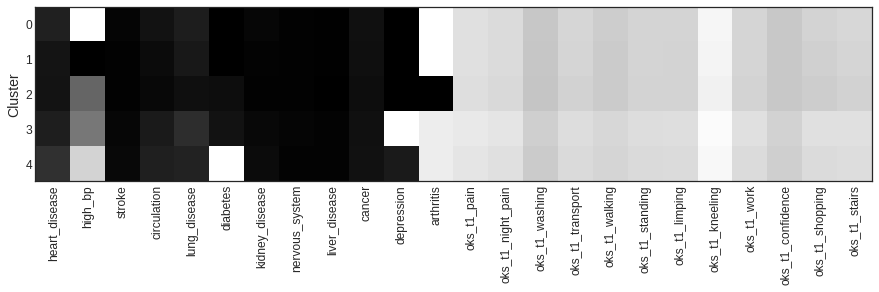

In [ ]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15,5))
plt.imshow(kmeans.cluster_centers_, interpolation='None')
plt.xticks(np.arange(24),comorb+oks_t1,rotation='vertical')
plt.ylabel('Cluster')
plt.show()

## Question 1a

Redo the clustering, now only using the comorbidity features; make a clustering with 3, 4 and 5 clusters

In [ ]:
# Answer question 1a
kmeans_3 = KMeans(n_clusters=3).fit(df_raw[comorb])
kmeans_4 = KMeans(n_clusters=4).fit(df_raw[comorb])
kmeans_5 = KMeans(n_clusters=5).fit(df_raw[comorb])

## Question 1b
Print and plot the cluster centers for each of the clusterings just generated, and describe (qualitatively) what sets a cluster apart from other clusters. 

In [ ]:
# Answer question 1b
kmeans_3.cluster_centers_

array([[8.41680746, 6.04424004, 8.89612665, 8.71866592, 8.53194418,
        8.07339966, 8.88861773, 8.92115637, 8.96545898, 8.61078781,
        8.52393467, 9.        ],
       [8.00227085, 1.        , 8.7980748 , 8.3594984 , 8.10869958,
        7.56626676, 8.73826893, 8.91816885, 8.94067643, 8.52348225,
        8.17027391, 1.        ],
       [8.37196808, 9.        , 8.91208944, 8.61413941, 8.25373394,
        8.33802792, 8.89108549, 8.91681881, 8.95757481, 8.57936467,
        8.16985725, 1.        ]])

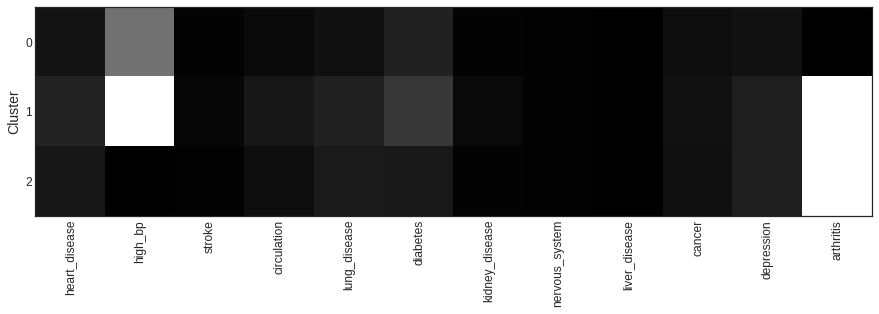

In [ ]:
# Answer question 1b - continued
plt.style.use('seaborn-white')
plt.figure(figsize=(15,5))
plt.imshow(kmeans_3.cluster_centers_, interpolation='None')
plt.xticks(np.arange(12),comorb,rotation='vertical')
plt.yticks(range(3))
plt.ylabel('Cluster')
plt.show()

In [ ]:
# Answer question 1b - continued
kmeans_4.cluster_centers_

array([[8.1163527 , 1.        , 8.81652683, 8.47570049, 8.1959791 ,
        9.        , 8.78676587, 8.92781384, 8.96010765, 8.53253126,
        8.28431217, 2.5344309 ],
       [8.5424259 , 9.        , 8.93525644, 8.78789534, 8.60796385,
        8.37480761, 8.92929845, 8.92135445, 8.96782682, 8.64768383,
        8.54917829, 9.        ],
       [8.41752284, 9.        , 8.91977859, 8.64393221, 8.27664253,
        9.        , 8.90082269, 8.9194753 , 8.96284642, 8.5864579 ,
        8.18914206, 1.        ],
       [7.74672572, 3.41493198, 8.77121164, 8.14558684, 8.01651376,
        1.        , 8.65732363, 8.88003796, 8.88155647, 8.50597912,
        7.9734894 , 2.07712749]])

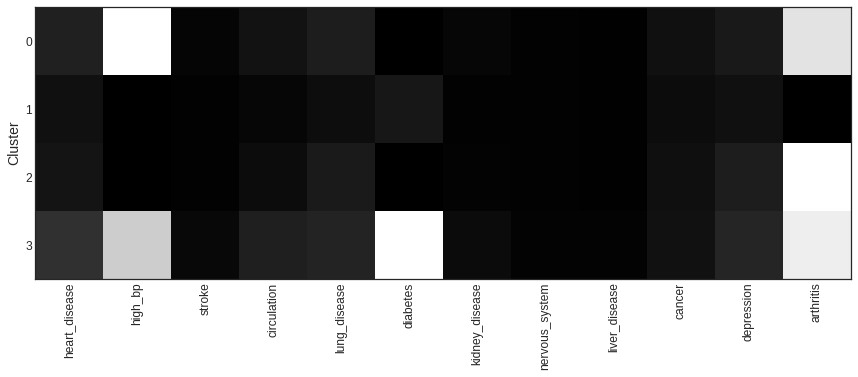

In [ ]:
# Answer question 1b - continued
plt.style.use('seaborn-white')
plt.figure(figsize=(15,5))
plt.imshow(kmeans_4.cluster_centers_, interpolation='None')
plt.xticks(np.arange(12),comorb,rotation='vertical')
plt.yticks(range(4))
plt.ylabel('Cluster')
plt.show()

In [ ]:
# Answer question 1b - continued
kmeans_5.cluster_centers_

array([[8.46365307, 6.31216418, 8.90265886, 8.74569279, 8.80892294,
        8.59565986, 8.90404548, 8.92151697, 8.97115818, 8.62366971,
        8.55627968, 9.        ],
       [8.48723545, 9.        , 8.92173676, 8.68912967, 9.        ,
        8.48084343, 8.90489925, 8.92064544, 8.96398644, 8.58935183,
        8.22999571, 1.        ],
       [8.08194795, 1.        , 8.81176701, 8.43314644, 8.1403178 ,
        9.        , 8.77298435, 8.92909434, 8.95632054, 8.52814436,
        8.22669735, 1.        ],
       [7.41361301, 1.56406368, 8.73987027, 7.92578553, 8.09695898,
        1.        , 8.60037065, 8.87667425, 8.87465251, 8.51006655,
        7.97161149, 2.42801786],
       [8.01021852, 8.99874234, 8.87046062, 8.39254834, 1.        ,
        8.094482  , 8.81386574, 8.89309857, 8.91447886, 8.47681182,
        7.71969816, 2.25263323]])

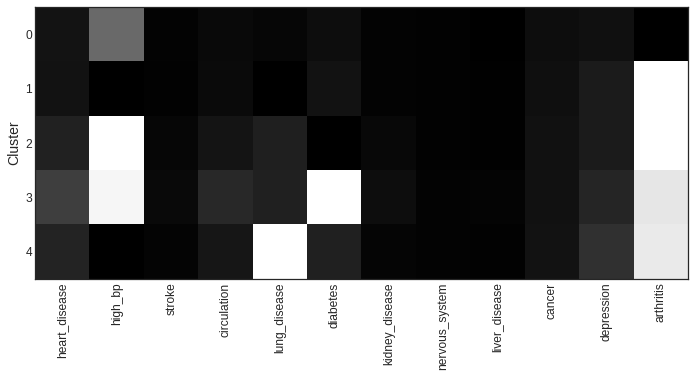

In [ ]:
# Answer question 1b - continued
plt.style.use('seaborn-white')
plt.figure(figsize=(15,5))
plt.imshow(kmeans_5.cluster_centers_, interpolation='None')
plt.xticks(np.arange(12),comorb,rotation='vertical')
plt.yticks(range(5))
plt.ylabel('Cluster')
plt.show()

Answer question 1 b - continued

Clusters seem to differ with respect to high blood pressure; lung disease, diabetes and arthritis.

The domain expert states that the model containing 3 clusters seems to be most useful. You wonder whether grouping the patients accordingly will result in three clearly distinguishable groups with respect to the development in quality of life, and decide to plot T0_VAS against T1_VAS for the three groups.

The first step is to add a feature to the data containing the clustering. 

In [ ]:
df_raw['cluster'] = kmeans_3.labels_

In [ ]:
df_raw['cluster'].value_counts()

2    57513
1    49761
0    31962
Name: cluster, dtype: int64

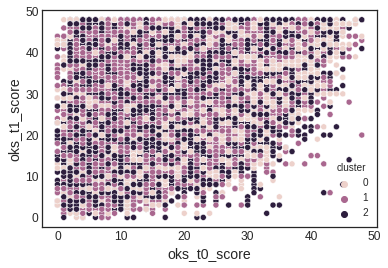

In [ ]:
sns.scatterplot(x ='oks_t0_score', y='oks_t1_score', hue='cluster', data=df_raw)

## Question 2

There are no clear patterns in the scatterplot. Instead of eyeballing for differences, let's show the means for every variable in the dataframe for each cluster, using groupby. Confirm that the clusters correspond to the groups with many/few cases of arthritis and high blood pressure.

In [ ]:
# Answer question 2
df_raw.groupby(df_raw['cluster']).mean()

,revision_flag,gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_eq5d_index_profile,t0_eq5d_index,t1_assisted,t1_assisted_by,t1_living_arrangements,t1_disability,t1_mobility,t1_self_care,t1_activity,t1_discomfort,t1_anxiety,t1_satisfaction,t1_sucess,t1_allergy,t1_bleeding,t1_wound,t1_urine,t1_further_surgery,t1_readmitted,t1_eq5d_index_profile,t1_eq5d_index,oks_eq_5d_index_t1_predicted,t0_eq_vas,t1_eq_vas,oks_eq_vas_t1_predicted,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_score,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs,oks_t1_score,oks_oks_t1_predicted
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.05,1.45,1.96,0.0,2.60,2.00,1.38,2.35,8.42,6.04,8.90,8.72,8.53,8.07,8.89,8.92,8.97,8.61,8.52,9.0,2.17,1.56,2.26,2.63,1.71,23501.80,0.46,2.02,8.40,1.40,2.02,1.54,1.29,1.63,1.81,1.38,2.32,1.55,2.47,2.72,2.59,2.61,2.07,2.03,16855.03,0.78,0.75,185.06,123.03,75.15,0.65,1.45,2.95,2.27,2.25,1.89,1.07,1.09,1.62,2.03,2.14,2.01,20.54,2.74,2.94,3.68,3.20,3.44,3.18,3.15,1.85,3.16,3.55,3.37,3.18,36.91,35.49
1,0.03,1.60,1.89,0.0,2.66,1.97,1.36,1.62,8.00,1.00,8.80,8.36,8.11,7.57,8.74,8.92,8.94,8.52,8.17,1.0,2.14,1.56,2.26,2.64,1.69,23184.94,0.39,2.00,8.33,1.43,1.88,1.66,1.35,1.75,1.90,1.43,2.39,1.53,2.57,2.83,2.65,2.71,2.06,2.01,18121.29,0.73,0.71,141.69,117.81,70.78,0.54,1.28,2.75,2.06,2.03,1.69,0.93,0.78,1.43,1.85,1.76,1.75,18.13,2.63,2.82,3.59,3.05,3.33,3.09,3.09,1.53,3.05,3.52,3.09,2.97,35.20,33.83
2,0.03,1.61,1.93,0.0,2.68,1.97,1.33,1.68,8.37,9.00,8.91,8.61,8.25,8.34,8.89,8.92,8.96,8.58,8.17,1.0,2.13,1.55,2.25,2.64,1.67,23081.03,0.41,2.01,8.49,1.40,1.93,1.60,1.32,1.70,1.88,1.42,2.34,1.52,2.53,2.81,2.65,2.69,2.05,2.01,17532.17,0.74,0.72,147.42,115.91,72.79,0.57,1.24,2.80,2.12,2.12,1.72,0.96,0.89,1.47,1.89,1.92,1.85,18.86,2.66,2.84,3.62,3.11,3.41,3.12,3.13,1.65,3.09,3.53,3.22,3.07,35.92,34.35


Clustering techniques can help you search for meaningful groupings in the data that have not been explicitly captured in a feature. Determining whether a proposed clustering is useful often comes down to a subjective assessment.

## Principal Component Analysis



Next, we will consider a dimensionality reduction technique. To this end, we apply a principal component analysis to groups of features that possibly overlap in the information they contain.

Determining the principal components requires first standardizing the data in order to express every considered feature on a similar scale.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dfc=df_raw[comorb + oks_t0 + oks_t1].copy()
df_scaled=pd.DataFrame(scaler.fit_transform(dfc), columns=[comorb + oks_t0 + oks_t1])
df_scaled.head()

,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs
0,-3.11,0.89,0.13,0.24,0.32,0.38,0.14,0.1,0.08,0.24,0.32,-0.55,-0.80,-0.22,-0.80,-0.12,-0.09,0.22,-0.76,0.09,-0.43,0.07,0.06,0.13,0.26,0.11,0.42,-0.10,-0.34,-0.12,0.72,0.23,0.81,0.49,0.62,-0.05
1,0.32,0.89,0.13,0.24,0.32,0.38,0.14,0.1,0.08,0.24,0.32,-0.55,0.59,1.97,1.16,1.75,-1.63,2.03,0.02,2.62,2.19,0.80,1.50,1.89,1.03,0.85,0.42,-0.10,0.54,0.85,0.72,0.91,-0.08,-0.56,0.62,0.82
2,0.32,0.89,0.13,0.24,0.32,0.38,0.14,0.1,0.08,0.24,0.32,1.83,0.59,1.97,1.16,1.75,-0.09,2.03,0.80,1.78,1.32,0.80,0.78,1.89,1.03,0.85,0.42,0.85,0.54,0.85,0.72,0.23,0.81,0.49,0.62,0.82
3,0.32,-1.12,0.13,0.24,0.32,0.38,0.14,0.1,0.08,0.24,0.32,-0.55,0.59,0.51,-0.80,-0.12,-0.09,0.22,0.80,-0.76,-0.43,0.80,0.78,0.13,0.26,-0.64,0.42,0.85,-2.11,0.85,0.72,-0.44,-0.08,-0.56,0.62,-0.05
4,0.32,-1.12,0.13,0.24,0.32,0.38,0.14,0.1,0.08,0.24,0.32,-0.55,-0.80,-0.22,1.16,-0.12,-0.09,-0.68,-0.76,0.09,-0.43,-1.40,-1.37,-1.63,-0.52,-0.64,0.42,-1.05,-1.23,-0.12,-0.10,0.23,-0.98,-0.56,-0.94,-1.80


Now that features are scaled, we can determine the principal components. Let's do this first for the features contained in oks_t0

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(oks_t0))
Principal_components=pca.fit_transform(df_scaled[oks_t0])
cols = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10', 'PC 11', 'PC 12']
pca_df = pd.DataFrame(data = Principal_components, columns = cols)
pca_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12
0,-0.60,-0.88,-0.36,-0.14,0.08,0.52,0.48,0.49,0.03,0.21,0.02,-0.35
1,4.45,0.17,-0.82,-2.14,2.30,1.37,-0.28,-0.69,-0.26,0.62,0.47,0.34
2,4.34,0.07,-0.36,-1.05,1.62,0.09,-0.17,-0.10,0.16,0.43,-0.41,-0.01
3,0.49,-0.21,0.94,-0.52,-0.92,0.18,-0.28,-0.07,0.53,-0.38,-0.12,-1.07
4,-1.98,0.66,-0.79,0.47,1.13,-1.43,0.12,0.06,-0.82,-0.16,0.36,0.65


The next step is to assess the amount of variation (information) that is captured in each of the principal components. A typical way to assess this is by visualizing it using a scree plot.

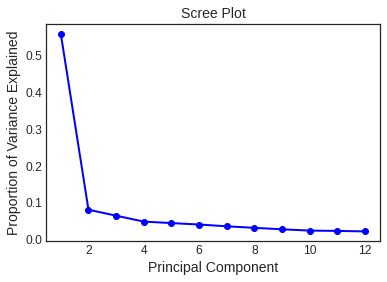

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

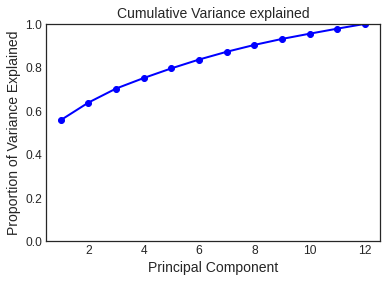

In [ ]:
# or using the cumulative proportion of variance explained
plt.plot(PC_values, pca.explained_variance_ratio_.cumsum(), 'bo-', linewidth=2)
plt.ylim(0, 1)
plt.title('Cumulative Variance explained')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

Much of the information in the data is now captured in the first principal component. By inspecting the loadings of our principal components, we can see which original features are contributing most to the first principal component. 

Each loading has a value between -1 and 1: the further away from zero, the more it contributes to the principal component.

In [ ]:
loadings = pd.DataFrame(pca.components_[:3].T, columns=['PC 1', 'PC 2', 'PC 3'], index=oks_t0)
loadings

,PC 1,PC 2,PC 3
oks_t0_pain,0.18,0.59,0.71
oks_t0_night_pain,0.28,-0.06,0.23
oks_t0_washing,0.18,0.71,-0.51
oks_t0_transport,0.31,-0.01,-0.24
oks_t0_walking,0.28,-0.08,0.10
oks_t0_standing,0.32,-0.10,0.11
oks_t0_limping,0.29,-0.23,0.18
oks_t0_kneeling,0.30,-0.25,-0.07
oks_t0_work,0.33,-0.04,0.04
oks_t0_confidence,0.29,-0.02,-0.07


Interestingly, all the oks_t0 features seem to contribute similarly to the first principal component, which suggests that there might be no redundant features in this set which could be removed from the questionnaires without losing information. 

## Question 3
Do the same for the group of comorbidity features and determine how many principle components are needed to capture 80% of the variance in these features.

In [ ]:
# Answer question 3
pca_comorb = PCA(n_components=len(comorb))
Principal_components_c=pca_comorb.fit_transform(df_scaled[comorb])
pca_c_df = pd.DataFrame(data = Principal_components_c, columns = cols)
pca_c_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12
0,0.35,-0.32,0.06,0.38,-1.42,1.01,-1.30,-0.86,1.08,-1.28e+00,1.61,0.23
1,-0.82,0.28,-0.40,-0.10,-0.05,-0.24,-0.48,-0.27,0.05,1.44e-01,0.23,0.59
2,-1.33,0.90,0.70,0.80,-0.16,0.78,0.56,-0.06,-0.25,3.22e-03,-0.20,-0.14
3,-0.18,-0.62,0.14,-0.41,0.31,-0.72,-0.62,0.21,-0.04,1.22e-01,-0.18,-0.70
4,-0.18,-0.62,0.14,-0.41,0.31,-0.72,-0.62,0.21,-0.04,1.22e-01,-0.18,-0.70


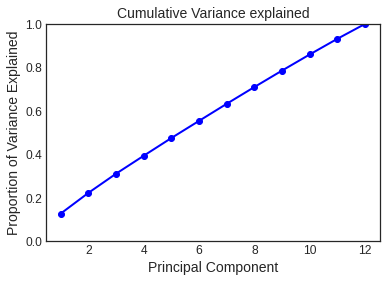

In [ ]:
# or using the cumulative proportion of variance explained
PC_values_c = np.arange(pca_comorb.n_components_) + 1
plt.plot(PC_values_c, pca_comorb.explained_variance_ratio_.cumsum(), 'bo-', linewidth=2)
plt.ylim(0, 1)
plt.title('Cumulative Variance explained')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
pca_comorb.explained_variance_ratio_.cumsum()

array([0.12772242, 0.22291596, 0.31114224, 0.39372375, 0.47525466,
       0.55411032, 0.63265571, 0.70969602, 0.78540369, 0.85954524,
       0.93162057, 1.        ])

Apparently the comorbidity features do not exhibit a lot of overlap in the information they contain, and all carry a comparable amount of information. At least 10 principal components are needed to capture >80% of the variance in these features.

# Conclusion

Clustering can be a useful technique for exploring the data for features that are implicitly present, but not explicitly captured in the data. Dimensionality reduction can help to express the data more concisely, which could potentially lead to better performance in down-the-line machine learning models. 

For more information, please make sure to check the sklearn documentation on clustering techniques and dimensionality reduction techniques:

https://scikit-learn.org/stable/modules/clustering.html

https://scikit-learn.org/stable/modules/unsupervised_reduction.html


